In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from pixpro.model import *

In [3]:
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt

In [4]:
from pixpro.data import *

crop_tf = A.Compose([
    A.RandomCrop(128, 128)
])

view1_tfs = A.Compose([
    #A.HorizontalFlip(p=0.5),
    A.ColorJitter(0.4, 0.4, 0.2, 0.1, p=0.8),
    A.ToGray(p=0.2),
    A.GaussianBlur(blur_limit=23, sigma_limit=(0.1, 2.0), p=1.0),
    A.Normalize(),
    ToTensorV2()
])

#technically optional, but used in the BYOL paper
view2_tfs = A.Compose([
    #A.HorizontalFlip(p=0.5),
    A.ColorJitter(0.4, 0.4, 0.2, 0.1, p=0.8),
    A.ToGray(p=0.2),
    A.GaussianBlur(blur_limit=23, sigma_limit=(0.1, 2.0), p=0.1),
    A.Solarize(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

data = ContrastData('./imagenette_data/', crop_tf, view1_tfs, view2_tfs)

Found 13394 images in directory


In [5]:
def move_channel_dim(image):
    image -= image.min()
    image /= image.max()
    image *= 255
    return np.rollaxis(image.astype(np.uint8), 0, 3)

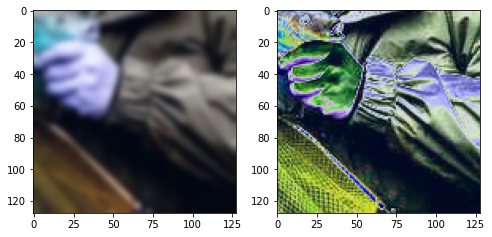

In [6]:
index = np.random.randint(0, len(data))
output = data[index]

view1 = output['view1']
view2 = output['view2']

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(move_channel_dim(view1.numpy()))
ax[1].imshow(move_channel_dim(view2.numpy()))

In [7]:
from pixpro.model import *
from torchvision.models import mobilenet_v2

In [8]:
model = PixPro(mobilenet_v2(), crop_size=(64, 64))

In [9]:
with torch.no_grad():
    y, yp, z, zp, v1, v2, distances = model(view1.unsqueeze(0), view2.unsqueeze(0))
    #y, yp, z, zp, distances, view1, view2

batch overlap: 0.766357421875


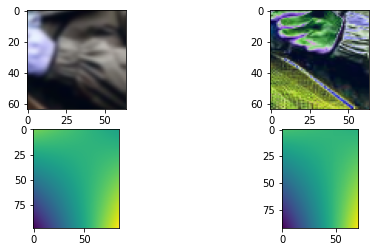

In [10]:
f, ax = plt.subplots(2, 2, figsize=(8, 4))
ax[0, 0].imshow(move_channel_dim(v1.squeeze().numpy()))
ax[0, 1].imshow(move_channel_dim(v2.squeeze().numpy()))
ax[1, 0].imshow(move_channel_dim(y.squeeze()[:1].numpy()))
ax[1, 1].imshow(move_channel_dim(zp.squeeze()[:1].numpy()))

In [11]:
criterion = ConsistencyLoss()

In [12]:
loss = criterion(y, yp, z, zp, distances)

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 55717437440 bytes. Error code 12 (Cannot allocate memory)